# Proteomics visualizations
In this notebook, we'll visualize our differentially abundant proteins and perform set operations to identify candidate proteins. We'll then compare these results to the transcriptomics to try and further narrow down meaningful candidate genes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from upsetplot import from_contents, plot, UpSet
from os import listdir
from os.path import splitext, isfile
from collections import defaultdict
from itertools import combinations
import warnings
import json
import sys
sys.path.append('../utils/')
%load_ext autoreload
%autoreload 2
from make_DEG_figure import makeDEGfigure

## Read in the data

In [2]:
run_date = '21Apr2025'

In [3]:
two_vs_21 = pd.read_csv('../data/proteomics/2_vs_21_diff_abund_permutation_test_TAIR10_14Apr2025.csv', header=67)
two_vs_21.head()

,#,Visible?,Starred?,Identified Proteins (5236),Accession Number,Alternate ID,Molecular Weight,Protein Grouping Ambiguity,Permutation Test (p-value) Benjamini-Hochberg (p < 0.00290),Log? Fold Change by Category (Set2 / Set 21),...,40D,Std Dev Log? Fold Change(40D),2A,Std Dev Log? Fold Change(2A),2B,Std Dev Log? Fold Change(2B),2C,Std Dev Log? Fold Change(2C),2D,Std Dev Log? Fold Change(2D)
0,1.1,True,Empty,| Symbols: RBCL | ribulose-bisphosphate carbox...,ATCG00490.1,NaN,53 kDa,True,0.6,0.00,...,-0.0691,0.244829,-0.0184,0.258310,-0.0162,0.260390,0.0475,0.290956,0.0419,0.323780
1,2.1,True,Empty,| Symbols: | Ribulose bisphosphate carboxylas...,AT5G38410.3,NaN,21 kDa,True,0.26,-0.07,...,0.0154,0.266525,0.0539,0.247674,0.0041,0.227914,0.0441,0.292816,0.002,0.377137
2,3,True,Empty,"| Symbols: ATPB, PB | ATP synthase subunit bet...",ATCG00480.1,NaN,54 kDa,True,0.6,0.00,...,-0.0374,0.222865,0.0188,0.231554,0.0232,0.225643,0.0911,0.268694,-0.0217,0.280220
3,5.1,True,Empty,| Symbols: RCA | rubisco activase | chr2:16570...,AT2G39730.1,NaN,52 kDa,True,0.21,0.04,...,0.0052,0.261222,0.0469,0.280420,-0.0058,0.256331,0.1589,0.255556,0.1356,0.269579
4,2.2,True,Empty,| Symbols: | Ribulose bisphosphate carboxylas...,AT5G38430.1,NaN,20 kDa,True,0.041,-0.12,...,-0.0225,0.247248,0.0827,0.224610,0.0279,0.212772,0.0757,0.291695,-0.0469,0.363205


In [4]:
forty_vs_21 = pd.read_csv('../data/proteomics/40_vs_21_diff_abund_permutation_test_TAIR10_14Apr2025.csv', header=67)
forty_vs_21.head()

,#,Visible?,Starred?,Identified Proteins (5236),Accession Number,Alternate ID,Molecular Weight,Protein Grouping Ambiguity,Permutation Test (p-value) Benjamini-Hochberg (p < 0.00456),Log? Fold Change by Category (Set 40 / Set 21),...,40D,Std Dev Log? Fold Change(40D),2A,Std Dev Log? Fold Change(2A),2B,Std Dev Log? Fold Change(2B),2C,Std Dev Log? Fold Change(2C),2D,Std Dev Log? Fold Change(2D)
0,1.1,True,Empty,| Symbols: RBCL | ribulose-bisphosphate carbox...,ATCG00490.1,NaN,53 kDa,True,0.18,-0.02,...,-0.0691,0.244829,-0.0184,0.258310,-0.0162,0.260390,0.0475,0.290956,0.0419,0.323780
1,2.1,True,Empty,| Symbols: | Ribulose bisphosphate carboxylas...,AT5G38410.3,NaN,21 kDa,True,0.49,-0.04,...,0.0154,0.266525,0.0539,0.247674,0.0041,0.227914,0.0441,0.292816,0.002,0.377137
2,3,True,Empty,"| Symbols: ATPB, PB | ATP synthase subunit bet...",ATCG00480.1,NaN,54 kDa,True,< 0.0001,-0.06,...,-0.0374,0.222865,0.0188,0.231554,0.0232,0.225643,0.0911,0.268694,-0.0217,0.280220
3,5.1,True,Empty,| Symbols: RCA | rubisco activase | chr2:16570...,AT2G39730.1,NaN,52 kDa,True,0.17,-0.05,...,0.0052,0.261222,0.0469,0.280420,-0.0058,0.256331,0.1589,0.255556,0.1356,0.269579
4,2.2,True,Empty,| Symbols: | Ribulose bisphosphate carboxylas...,AT5G38430.1,NaN,20 kDa,True,0.003,-0.14,...,-0.0225,0.247248,0.0827,0.224610,0.0279,0.212772,0.0757,0.291695,-0.0469,0.363205


In [5]:
two_lfc_name = 'Log? Fold Change by Category (Set2 / Set 21)'
forty_lfc_name = 'Log? Fold Change by Category (Set 40 / Set 21)'
two_pval_col_name = "Permutation Test (p-value) Benjamini-Hochberg (p < 0.00290)"
forty_pval_col_name = "Permutation Test (p-value) Benjamini-Hochberg (p < 0.00456)"
two_pval_cutoff = 0.00290
forty_pval_cutoff = 0.00456

Do basic dataframe cleaning specific to the Scaffold output for the string-formatted numerical values:

In [6]:
two_vs_21[two_pval_col_name] = two_vs_21[two_pval_col_name].replace('< 0.0001', '0.00009')
forty_vs_21[forty_pval_col_name] = forty_vs_21[forty_pval_col_name].replace('< 0.0001', '0.00009')

two_vs_21[two_pval_col_name] = two_vs_21[two_pval_col_name].replace('--', np.nan)
forty_vs_21[forty_pval_col_name] = forty_vs_21[forty_pval_col_name].replace('--', np.nan)

two_vs_21[two_pval_col_name] = two_vs_21[two_pval_col_name].astype('float64')
forty_vs_21[forty_pval_col_name] = forty_vs_21[forty_pval_col_name].astype('float64')

We also want to get rid of any row that says "No data" in any of the columns, as these are the proteins without unique peptide evidence or low-confidence peptide evidence that we want to remove from the analysis:

In [7]:
print(f'Shapes of two and forty: {two_vs_21.shape}, {forty_vs_21.shape}')
two_vs_21 = two_vs_21[~two_vs_21.eq('No data').any(axis=1)]
forty_vs_21 = forty_vs_21[~forty_vs_21.eq('No data').any(axis=1)]
print(f'Shapes of two and forty after dropping No data rows: {two_vs_21.shape}, {forty_vs_21.shape}')

Shapes of two and forty: (5238, 43), (5238, 43)
Shapes of two and forty after dropping No data rows: (4464, 43), (4464, 43)


We also want to create a column where we drop the isoform numbers from the protein ID's to be able to match them up with the transcriptomics later on:

In [8]:
two_vs_21.loc[:, 'base_accession_number'] = two_vs_21['Accession Number'].str.split('.').str[0]
forty_vs_21.loc[:, 'base_accession_number'] = forty_vs_21['Accession Number'].str.split('.').str[0]

Save the overall list of identified proteins for later:

In [9]:
two_vs_21.shape, forty_vs_21.shape # They are the same lists, just with a different comparison

((4464, 44), (4464, 44))

In [10]:
all_proteins = two_vs_21['base_accession_number'].tolist()

Filter out any proteins that aren't significantly expressed in each condition:

In [11]:
initial_two_num = len(two_vs_21)
two_vs_21 = two_vs_21[two_vs_21[two_pval_col_name] < two_pval_cutoff]
print(f'There are {len(two_vs_21)} differentially expressed proteins at 2% oxygen, which is {(len(two_vs_21)/initial_two_num)*100:.2f}% of the total proteins.')

There are 303 differentially expressed proteins at 2% oxygen, which is 6.79% of the total proteins.


In [12]:
initial_forty_num = len(forty_vs_21)
forty_vs_21 = forty_vs_21[forty_vs_21[forty_pval_col_name] < forty_pval_cutoff]
print(f'There are {len(forty_vs_21)} differentially expressed proteins at 40% oxygen, which is {(len(forty_vs_21)/initial_forty_num)*100:.2f}% of the total proteins.')

There are 476 differentially expressed proteins at 40% oxygen, which is 10.66% of the total proteins.


Put the two dataframes in a dict to make later plotting easier:

In [13]:
df_references = {
    '2_vs_21': {'lfc_name': two_lfc_name, 'pval_col_name': two_pval_col_name, 'pval_cutoff': two_pval_cutoff},
    '40_vs_21': {'lfc_name': forty_lfc_name, 'pval_col_name': forty_pval_col_name, 'pval_cutoff': forty_pval_cutoff}
}

comparisons = {
    '2_vs_21': two_vs_21,
    '40_vs_21': forty_vs_21
}

## Basic characterization
Let's start by plotting some histograms of the log fold change for the significant proteins:

Text(0.5, 0.01, 'Log2FoldChange')

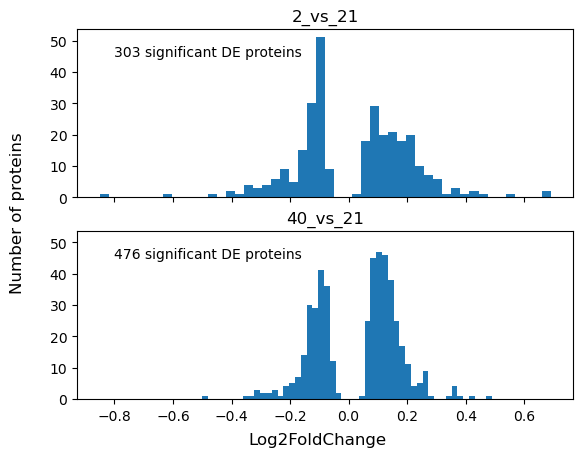

In [14]:
fig, axs = plt.subplots(2, sharex=True, sharey=True)

for comp, ax in zip(comparisons, axs):
    df = comparisons[comp]
    ax.hist(df[df_references[comp]['lfc_name']], bins=50)
    ax.set_title(comp)
    ax.text(-0.8, 45, f'{len(df)} significant DE proteins')

fig.supylabel('Number of proteins')
fig.supxlabel('Log2FoldChange')

Save the names of the DE proteins for later:

In [15]:
all_de_proteins = list(set(comparisons['2_vs_21']['base_accession_number'].tolist() + comparisons['40_vs_21']['base_accession_number'].tolist()))

## Set operations
We want to know which proteins exhibit opposite behavior at the two conditions.

In [16]:
two_forty = pd.merge(two_vs_21, forty_vs_21, left_on='base_accession_number', right_on='base_accession_number', suffixes=('_2o2', '_40o2'))
protein_opposites = two_forty[two_forty[two_lfc_name]*two_forty[forty_lfc_name] < 0]
protein_opposites.shape

(21, 87)

Only 21 proteins!

## Comparison to transcriptomic data
We now want to see if any of these proteins overlap with the candidates we saw in our transcriptomic analysis. We'll use an UpsetPlot to look at the general overlap. First, let's see how many of our differentially expressed genes actually appear in the proteomics dataset; proteomics is much less complete than transcriptomics, so we'd first like to see what genes are represented at all before we check which ones are differentially abundant as proteins.

In [17]:
data_path = '../data/Araport11_outputs_ALL/gene_lists_with_descriptions/'
transcriptomic_comparisons = {}
for f in listdir(data_path):
    comp = splitext(f)[0]
    if isfile(f'{data_path}/{f}'):
        transcriptomic_comparisons[comp] = pd.read_csv(f'{data_path}/{f}')

In [18]:
for comp, df in transcriptomic_comparisons.items():
    overlap = set(df.gene_id.tolist()).intersection(set(all_proteins))
    print(f'Comparison {comp} has {len(overlap)} (of {len(df)}) genes represented in the proteomics dataset. This is {(len(overlap)/len(df))*100:.2f}% of the DEGs in this comparison.')

Comparison time_filtered_2_vs_21_Araport11_TAIR10_21Apr2025 has 320 (of 2006) genes represented in the proteomics dataset. This is 15.95% of the DEGs in this comparison.
Comparison time_comparison_opposites_Araport11_TAIR10_21Apr2025_darkmode has 3 (of 17) genes represented in the proteomics dataset. This is 17.65% of the DEGs in this comparison.
Comparison all_comparisons_opposites_Araport11_TAIR10_21Apr2025 has 1 (of 1) genes represented in the proteomics dataset. This is 100.00% of the DEGs in this comparison.
Comparison hour7_opposite_behavior_genes_Araport11_TAIR10_21Apr2025_darkmode has 4 (of 13) genes represented in the proteomics dataset. This is 30.77% of the DEGs in this comparison.
Comparison hour7_opposite_behavior_genes_Araport11_TAIR10_15Apr2025 has 4 (of 13) genes represented in the proteomics dataset. This is 30.77% of the DEGs in this comparison.
Comparison 7h_o2_40_21_Araport11_TAIR10_21Apr2025_darkmode has 9 (of 40) genes represented in the proteomics dataset. This i

**The coverage of the proteomics seems much worse now that we've gotten TAIR ID's from the MaxQuant search instead of from the TAIR to UniProt file.** Now let's take a look at, of the genes that are represented in the proteomics dataset, which are significantly upregulated in any way in the proteomics.

In [19]:
for comp, df in transcriptomic_comparisons.items():
    overlap = set(df.gene_id.tolist()).intersection(all_de_proteins)
    print(f'Comparison {comp} has {len(overlap)} (of {len(df)}) genes that are differentially abundant in the proteomics dataset. This is {(len(overlap)/len(df))*100:.2f}% of the DEGs in this comparison.')

Comparison time_filtered_2_vs_21_Araport11_TAIR10_21Apr2025 has 61 (of 2006) genes that are differentially abundant in the proteomics dataset. This is 3.04% of the DEGs in this comparison.
Comparison time_comparison_opposites_Araport11_TAIR10_21Apr2025_darkmode has 1 (of 17) genes that are differentially abundant in the proteomics dataset. This is 5.88% of the DEGs in this comparison.
Comparison all_comparisons_opposites_Araport11_TAIR10_21Apr2025 has 0 (of 1) genes that are differentially abundant in the proteomics dataset. This is 0.00% of the DEGs in this comparison.
Comparison hour7_opposite_behavior_genes_Araport11_TAIR10_21Apr2025_darkmode has 1 (of 13) genes that are differentially abundant in the proteomics dataset. This is 7.69% of the DEGs in this comparison.
Comparison hour7_opposite_behavior_genes_Araport11_TAIR10_15Apr2025 has 1 (of 13) genes that are differentially abundant in the proteomics dataset. This is 7.69% of the DEGs in this comparison.
Comparison 7h_o2_40_21_Ara

In order to deal with the fact that many of the transcripts' resulting proteins are not present, we're going to remove them for the purpose of the next analysis. We are fundamentally interested in proteins that show the same direction of change in the transcriptome vs. the proteome, but if  protein isn't present in the analysis, then we can exclude it.

In [20]:
transcriptomics_filtered = {}
for comp, df in transcriptomic_comparisons.items():
    overlap = set(df.gene_id.tolist()).intersection(all_proteins)
    filtered_df = df[df.gene_id.isin(overlap)]
    transcriptomics_filtered[comp] = filtered_df

Wrangling the data for input into UpSetPlot:

In [21]:
genes_in_comps = {}
for comp, df in transcriptomics_filtered.items():
    genes_in_comps[comp] = list(set(df.gene_id.tolist()))
genes_in_comps['proteomics_opposites'] = list(set(protein_opposites['base_accession_number'].tolist()))
genes_in_comps['proteomics_2_DE'] = list(set(two_vs_21['base_accession_number'].tolist()))
genes_in_comps['proteomics_40_DE'] = list(set(forty_vs_21['base_accession_number'].tolist()))
genes_in_comps = dict(sorted(genes_in_comps.items()))

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

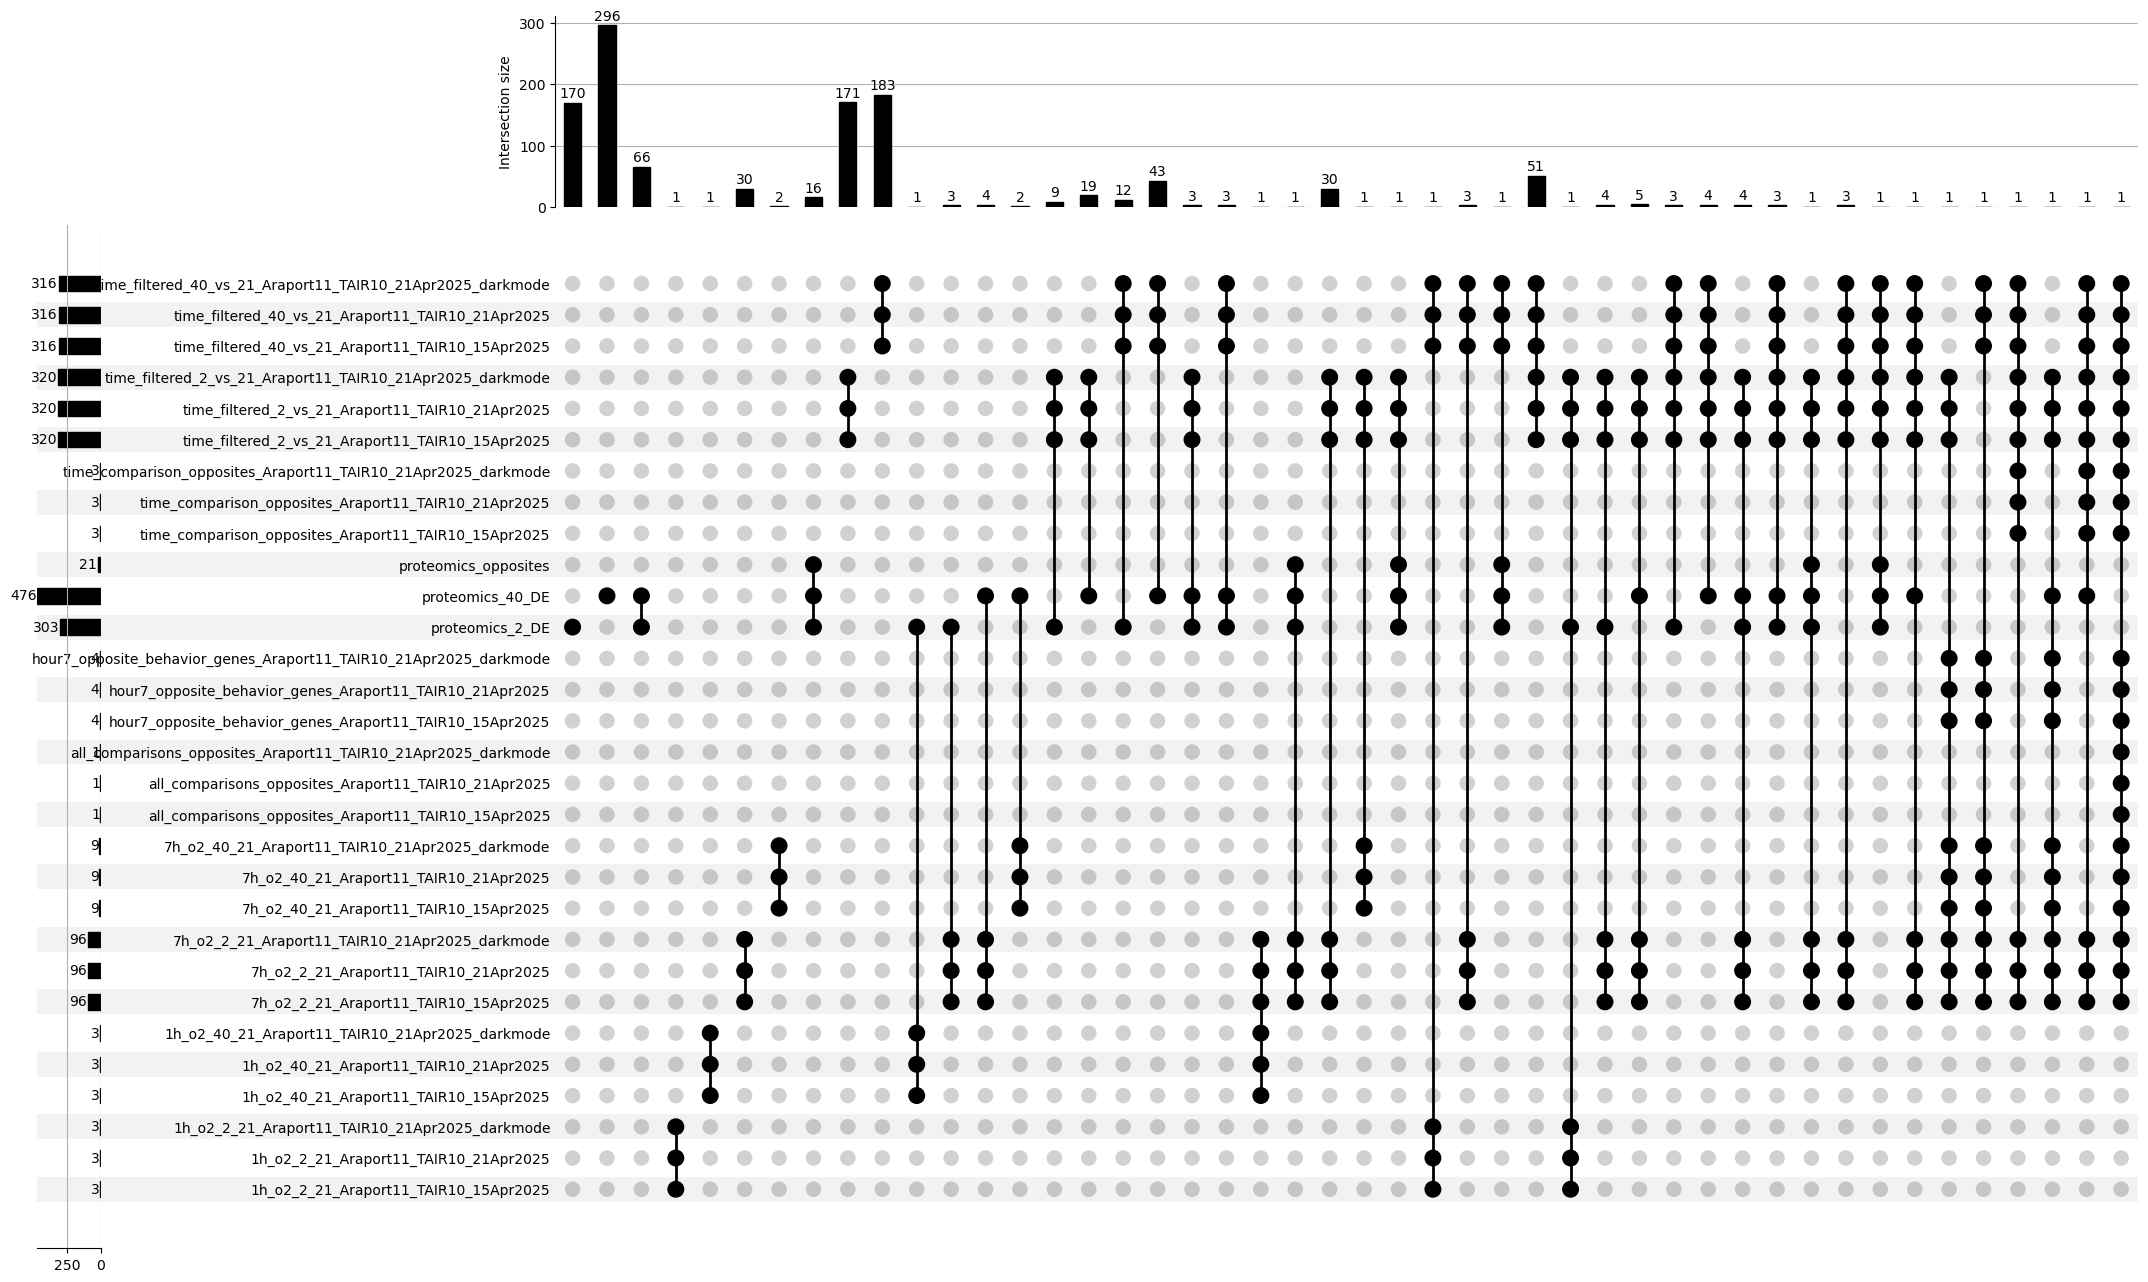

In [22]:
warnings. filterwarnings('ignore') 
to_plot = from_contents(genes_in_comps)
plot(to_plot, show_counts=True, sort_categories_by='input')

We can make this a little more visually simple by just looking for genes with opposite behaviors at the conditions:

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

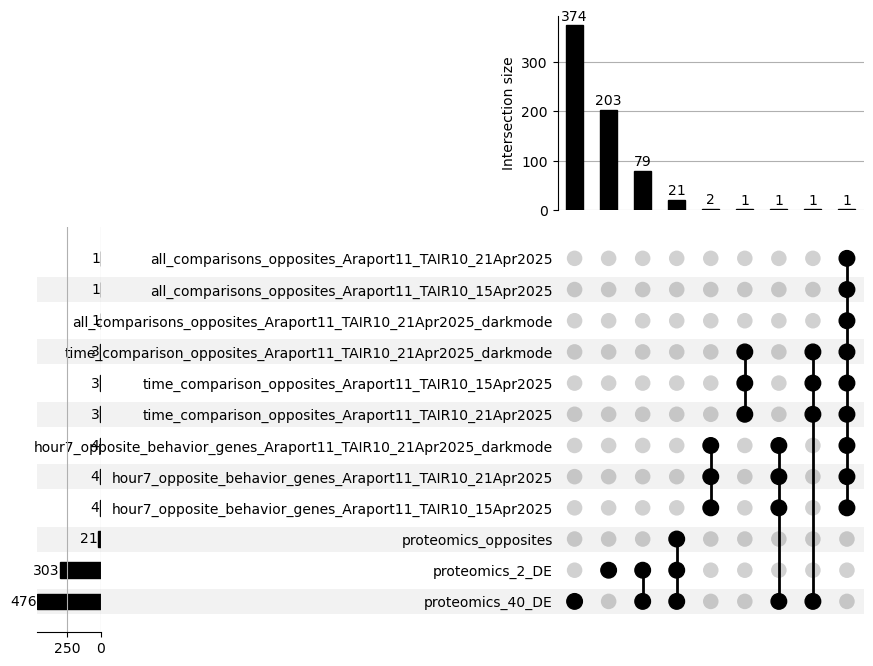

In [23]:
warnings. filterwarnings('ignore') 
keys_to_keep = ['proteomics_opposites', 'proteomics_2_DE', 'proteomics_40_DE']
to_plot = from_contents({k: v for k, v in genes_in_comps.items() if k in keys_to_keep or 'opposite' in k})
plot(to_plot, show_counts=True)

Unfortunately, inone of our opposite behavior DEGs appear in the proteomics dataset.

## Looking for photosynthetic proteins
We also want to see if our photosynthesis proteins are present in the dataset.

In [24]:
with open('../data/photosynthesis_genes/all_photosynthesis_genes_unique.json') as f:
    all_photosynth_genes = json.load(f)

In [25]:
proteomics_genes = {
    'proteomics_opposites': list(set(protein_opposites['base_accession_number'].tolist())),
    'proteomics_2_DE': list(set(two_vs_21['base_accession_number'].tolist())),
    'proteomics_40_DE': list(set(forty_vs_21['base_accession_number'].tolist()))
}

proteomics_genes = {k: [i.lower() for i in v] for k, v in proteomics_genes.items()}
legend_semantic = {'plastidCut2': 'PlastidCut 2', 'carb_met': 'Carbohydrate metabolism', 'lipids': 'Lipid metabolism', 'light_rxns': 'Light reactions', 'photorespiration': 'Photorespiration', 'ros_genes': 'ROS'}
all_photosynth_genes = {legend_semantic[k]: [i.lower() for i in v] for k, v in all_photosynth_genes.items()}
gene_groups = proteomics_genes
gene_groups.update(all_photosynth_genes)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

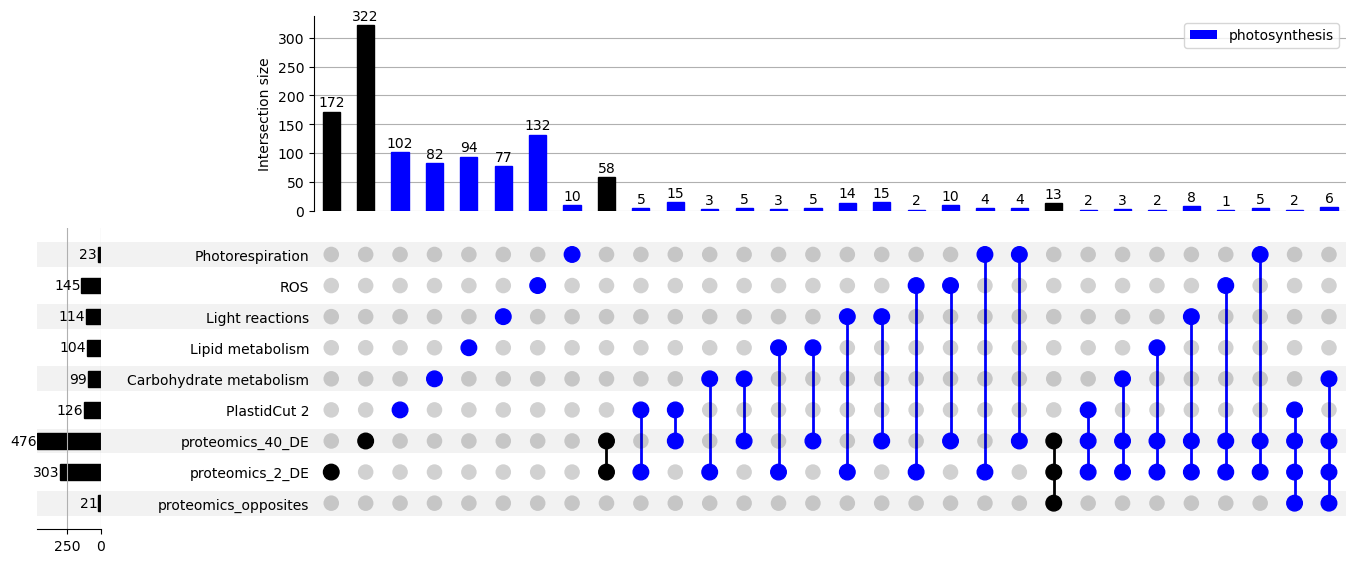

In [26]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(gene_groups)

upset = UpSet(to_plot, show_counts=True, sort_categories_by='input')
for c in all_photosynth_genes.keys():
    upset.style_subsets(present=c, facecolor="blue", label="photosynthesis")
upset.plot()

In [27]:
ara = pd.read_csv('../data/external_data/gene_aliases_20241231.txt', sep='\t', header=0, encoding='Windows-1252')
tair2gene = {k.lower(): v for k, v in ara.set_index('locus_name')[['symbol']].to_dict()['symbol'].items()}
semantic_names = {
    'proteomics_2_DE': '2% vs. 21% oxygen at 7 hours',
    'proteomics_40_DE': '40% vs. 21% oxygen at 7 hours'
}
photosynth_colors = {'PlastidCut 2': 'springgreen', 'Carbohydrate metabolism': 'wheat', 'Lipid metabolism': 'mediumslateblue', 'Light reactions': 'yellow', 'Photorespiration': 'mediumorchid', 'ROS': 'lightskyblue'}

In [28]:
two_expression_change = two_vs_21.rename(columns={two_lfc_name: 'log2FoldChange'})

In [29]:
forty_expression_change = forty_vs_21.rename(columns={forty_lfc_name: 'log2FoldChange'})

In [30]:
proteomics_to_compare = {
'proteomics_2_DE': two_expression_change,
'proteomics_40_DE': forty_expression_change
}

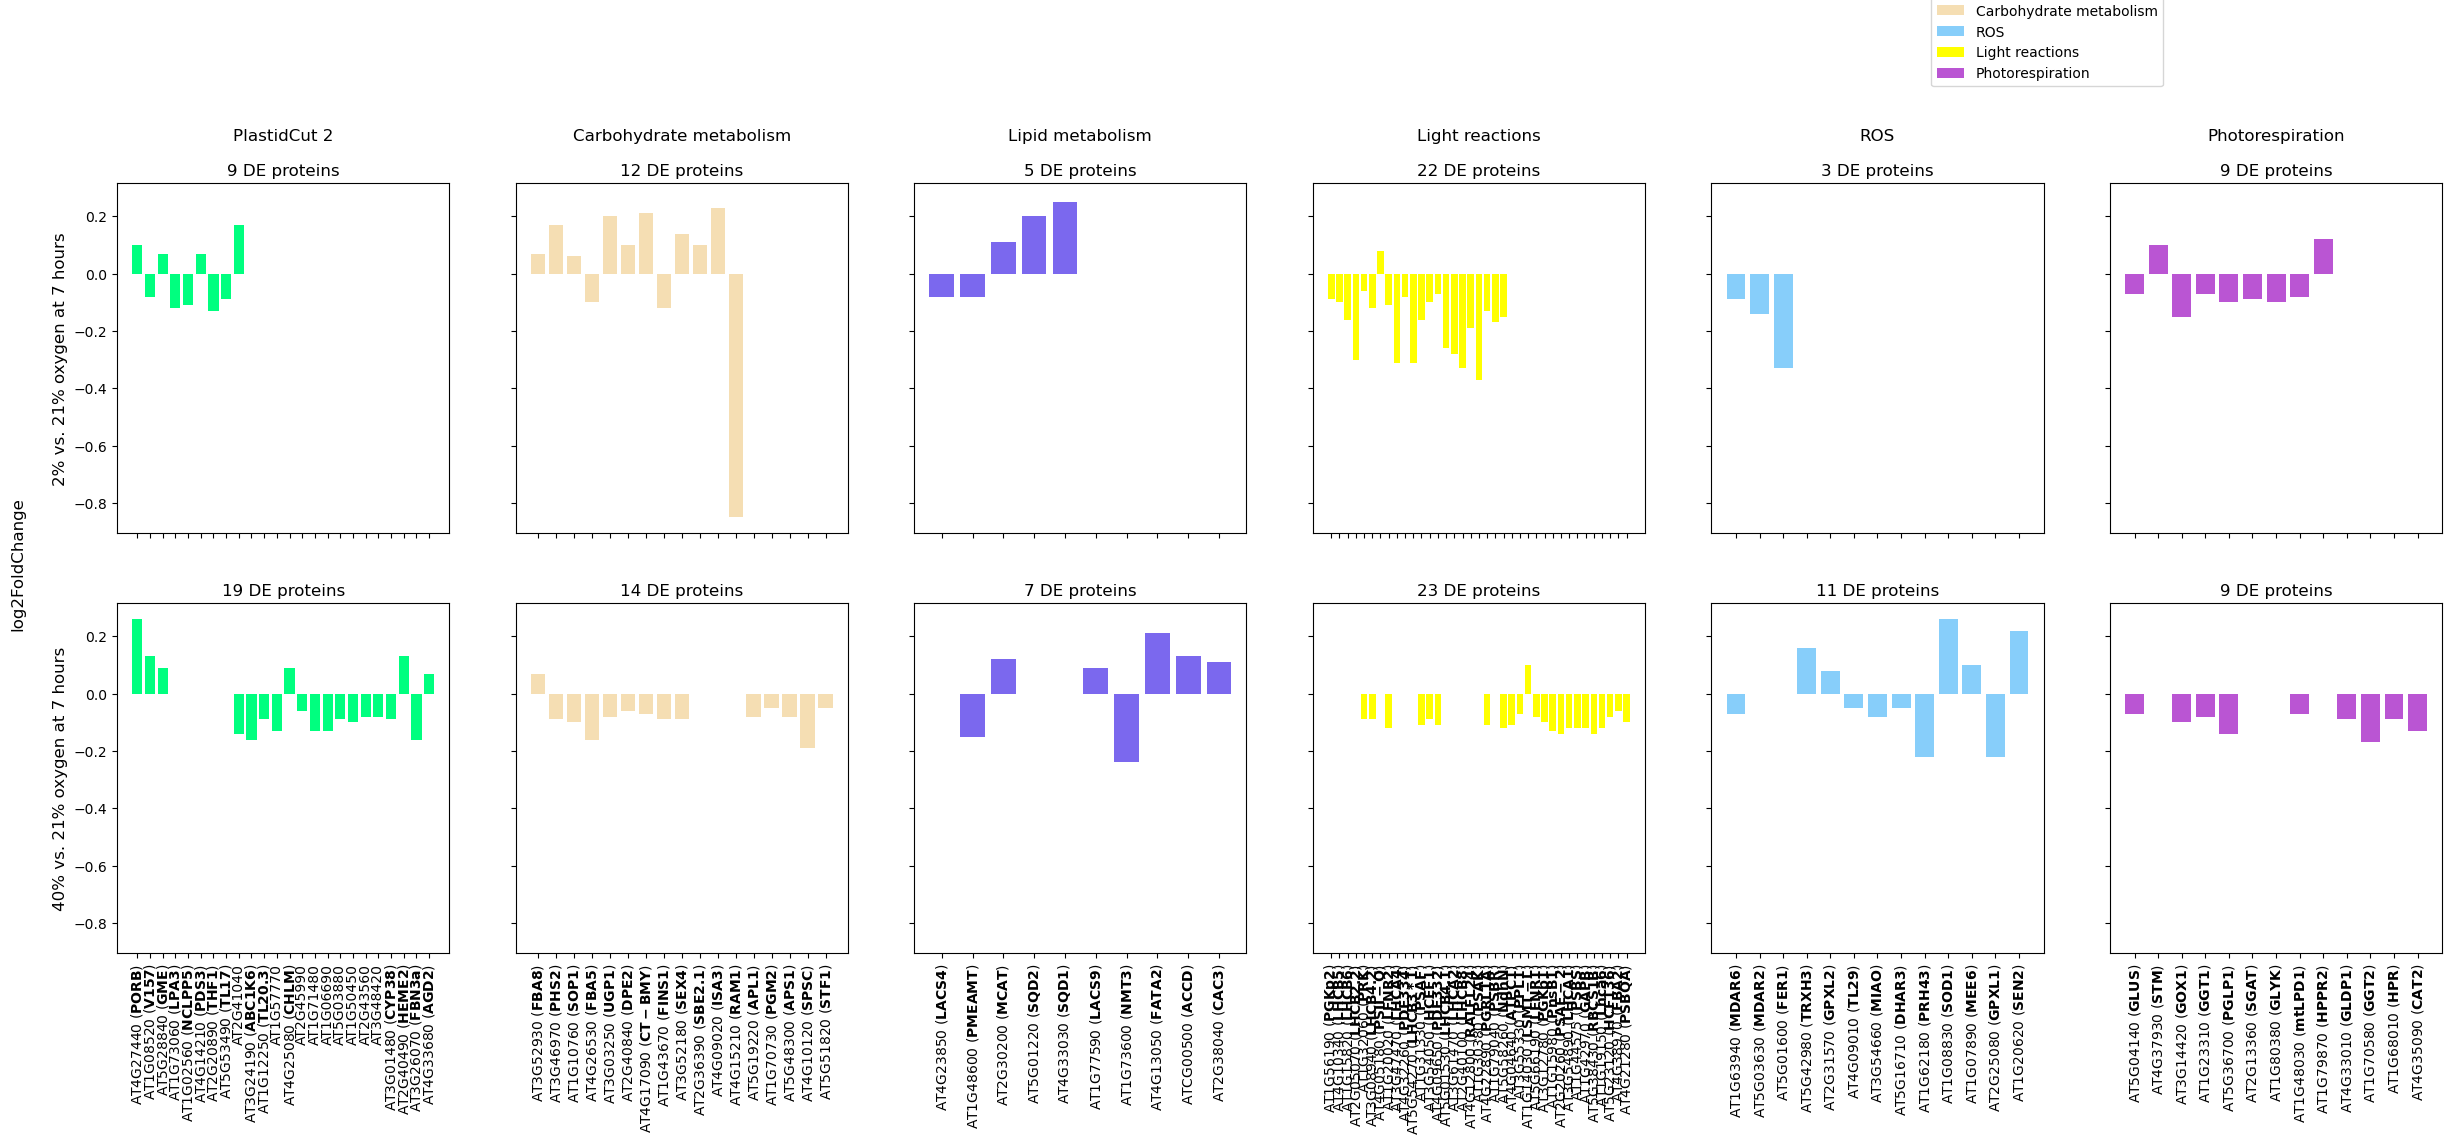

In [31]:
makeDEGfigure(proteomics_to_compare, all_photosynth_genes, photosynth_colors, semantic_names, tair2gene, id_col='base_accession_number', title_name='proteins', separate_columns=True, show_all_x=False)
plt.savefig(f'../data/Araport11_outputs_ALL/figures/daps_abundance_photosynthesis_{run_date}.png', format='png', dpi=600, bbox_inches='tight')